<img src='./img/logo_header.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='100%'></img>

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./22_Sentinel-3_SLSTR_FRP.ipynb"><< 22 - Sentinel-3 SLSTR FRP </a><span style="float:right;"><a href="./32_Sentinel-5P_TROPOMI_UVAI.ipynb"> 32 - Sentinel-5P TROPOMI UVAI >></a></span>

# 3.1 Copernicus Sentinel-5P TROPOMI Carbon monoxide (CO)

###  Example Portugal fires in July 2020

A precursor satellite mission, Sentinel-5P aims to fill in the data gap and provide data continuity between the retirement of the Envisat satellite and NASA's Aura mission and the launch of Sentinel-5. The Copernicus Sentinel-5P mission is being used to closely monitor the changes in air quality and was launched in October 2017.

Sentinel-5P Pre-Ops data are disseminated in the `netCDF` format and can be downloaded via the [Copernicus Open Access Hub](https://scihub.copernicus.eu/).

Sentinel-5P carries the `TROPOMI` instrument, which is a spectrometer in the UV-VIS-NIR-SWIR spectral range. `TROPOMI` provides measurements on:
* `Ozone`
* `NO`<sub>`2`</sub>
* `SO`<sub>`2`</sub>
* `Formaldehyde`
* `Aerosol`
* `Carbon monoxide`
* `Methane`
* `Clouds`

This notebook provides an introduction to the Sentinel-5P TROPOMI Carbon monoxide data and how it can be used to monitor wildfires. The notebook examines the **Portugal wildfires** which occured between 25-27 July 2020.

#### Module outline:
* [1 - Load and browse Sentinel-5P data](#load_s5P)
* [2 - Plotting example - Sentinel-5P data](#plotting_s5P)

#### Load required libraries

In [2]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
warnings.simplefilter(action = "ignore", category = UserWarning)

##### Load helper functions

In [3]:
%run ./functions.ipynb

<hr>

## <a id="load_s5P"></a>Load and browse Sentinel-5P data

A Sentinel-5P TROPOMI Aerosol Index Level 2 file is organised in two groups: `PRODUCT` and `METADATA`. The `PRODUCT` group stores the main data fields of the product, including `latitude`, `longitude` and the variable itself. The `METADATA` group provides additional metadata items.

Sentinel-5P TROPOMI variables have the following dimensions:
* `scanline`: the number of measurements in the granule / along-track dimension index
* `ground_pixel`: the number of spectra in a measurement / across-track dimension index
* `time`: time reference for the data
* `corner`: pixel corner index

Sentinel-5P TROPOMI data is disseminated in `netCDF`. You can load a `netCDF` file with the `open_dataset()` function of the xarray library. In order to load the variable as part of a Sentinel-5P data files, you have to specify the following keyword arguments: 
- `group='PRODUCT'`: to load the `PRODUCT` group

Let us load a Sentinel-5P TROPOMI data file as `xarray.Dataset` from 27 July 2020 and inspect the data structure:

In [6]:
file = xr.open_dataset('./eodata/sentinel5p/co/2020/07/27/S5P_OFFL_L2__CO_____20200727T125510_20200727T143639_14445_01_010302_20200802T045214.nc', group='PRODUCT')
file

<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 215, layer: 50, scanline: 4173, time: 1)
Coordinates:
  * scanline                               (scanline) float64 0.0 ... 4.172e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 214.0
  * time                                   (time) datetime64[ns] 2020-07-27
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) float32 49500.0 ... 500.0
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                             (time, scanline) datetime64[ns] ...
    time_utc                               (time, scanline) object ...
    qa_value                               (time, scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column            (time, scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column_precision  (time, scanline, ground_pixel) float32 ...

You see that the loaded data object contains five dimensions and five data variables:

* **Dimensions**:
  * `scanline` 
  * `ground_pixel`
  * `time`
  * `corner`
  * `layer`

* **Data variables**:
  * `delta_time`: the offset of individual measurements within the granule, given in milliseconds
  * `time_utc`: valid time stamp of the data
  * `qa_value`: quality descriptor, varying between 0 (nodata) and 1 (full quality data).
  * `carbonmonoxide_total_column`
  * `carbonmonoxide_total_column_precision`

### <a id='data_retrieve_s5P'></a>Retrieve the variable `carbonmonoxide_total_column` as xarray.DataArray

You can specify one variable of interest by putting the name of the variable into square brackets `[]` and get more detailed information about the variable. E.g. `carbonmonoxide_total_column` is the 'Atmosphere mole content of carbon monoxide', has the unit mol m<sup>-2</sup> and has three dimensions, `time`, `scanline` and `ground_pixel` respectively.

In [134]:
co = file['carbonmonoxide_total_column']
co

<xarray.DataArray 'carbonmonoxide_total_column' (time: 1, scanline: 4173, ground_pixel: 215)>
[897195 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.171e+03 4.172e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
  * time          (time) datetime64[ns] 2020-07-27
    latitude      (time, scanline, ground_pixel) float32 ...
    longitude     (time, scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

You can do this for the available variables, but also for the dimensions latitude and longitude.

In [135]:
latitude = co['latitude']
longitude = co['longitude']

print('Latitude')
print(latitude)
print('Longitude')
print(longitude)

Latitude
<xarray.DataArray 'latitude' (time: 1, scanline: 4173, ground_pixel: 215)>
[897195 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.171e+03 4.172e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
  * time          (time) datetime64[ns] 2020-07-27
    latitude      (time, scanline, ground_pixel) float32 ...
    longitude     (time, scanline, ground_pixel) float32 ...
Attributes:
    long_name:      pixel center latitude
    units:          degrees_north
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      90.0
    bounds:         /PRODUCT/SUPPORT_DATA/GEOLOCATIONS/latitude_bounds
Longitude
<xarray.DataArray 'longitude' (time: 1, scanline: 4173, ground_pixel: 215)>
[897195 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.171e+03 4.172e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
  * time          

You can retrieve the array values of the variable with squared brackets: `[:,:,:]`. One single time step can be selected by specifying one value of the time dimension, e.g. `[0,:,:]`.

In [136]:
co_2707 = co[0,:,:]
co_2707

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 4173, ground_pixel: 215)>
[897195 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.171e+03 4.172e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2020-07-27
    latitude      (scanline, ground_pixel) float32 ...
    longitude     (scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

The attributes of the `xarray.DataArray` hold the entry `multiplication_factor_to_convert_to_molecules_percm2`, which is a conversion factor that has to be applied to convert the data from `mol per m`<sup>`2`</sup> to `molecules per cm`<sup>`2`</sup>.


In [137]:
conversion_factor = co_2707.multiplication_factor_to_convert_to_molecules_percm2
conversion_factor

6.022141e+19

Additionally, you can save the attribute `longname`, which you can make use of when visualizing the data.

In [138]:
longname = co_2707.long_name

longname

'Vertically integrated CO column'

## <a id="plotting_s5P"></a>Plotting example - Sentinel-5P data

The next step is to visualize the dataset. You can use the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh), which makes use of matploblib's function `pcolormesh` and the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) library.

With `?visualize_pcolormesh` you can open the function's docstring to see what keyword arguments are needed to prepare your plot.

In [139]:
?visualize_pcolormesh

Signature:
visualize_pcolormesh(
    data_array,
    longitude,
    latitude,
    projection,
    color_scale,
    unit,
    long_name,
    vmin,
    vmax,
    set_global=True,
    lonmin=-180,
    lonmax=180,
    latmin=-90,
    latmax=90,
)
Docstring:
Visualizes a xarray.DataArray with matplotlib's pcolormesh function.

Parameters:
    data_array(xarray.DataArray): xarray.DataArray holding the data values
    longitude(xarray.DataArray): xarray.DataArray holding the longitude values
    latitude(xarray.DataArray): xarray.DataArray holding the latitude values
    projection(str): a projection provided by the cartopy library, e.g. ccrs.PlateCarree()
    color_scale(str): string taken from matplotlib's color ramp reference
    unit(str): the unit of the parameter, taken from the NetCDF file if possible
    long_name(str): long name of the parameter, taken from the NetCDF file if possible
    vmin(int): minimum number on visualisation legend
    vmax(int): maximum number on visualisation

In order to make it easier to visualize the Carbon Monoxide values, we apply the conversion factor to the `xarray.DataArray`. This converts the Carbon Monoxide values from *mol per m<sup>2</sup>* to *molecules per cm<sup>2</sup>*.

In [140]:
co_2707_converted =  co_2707*conversion_factor
co_2707_converted

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 4173, ground_pixel: 215)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.171e+03 4.172e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2020-07-27
    latitude      (scanline, ground_pixel) float32 ...
    longitude     (scanline, ground_pixel) float32 ...

For visualization, you can use the function [visualize_pcolormesh](../functions.ipynb#visualize_pcolormesh) to visualize the data. The following keyword arguments have to be defined:
* `data_array`
* `longitude`
* `latitude`
* `projection`
* `color palette`
* `unit`
* `long_name`
* `vmin`, 
* `vmax`
* `extent (lonmin, lonmax, latmin, latmax)`
* `set_global`

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Vertically integrated CO column 2020-07-27T00:00:00.000000000'}>)

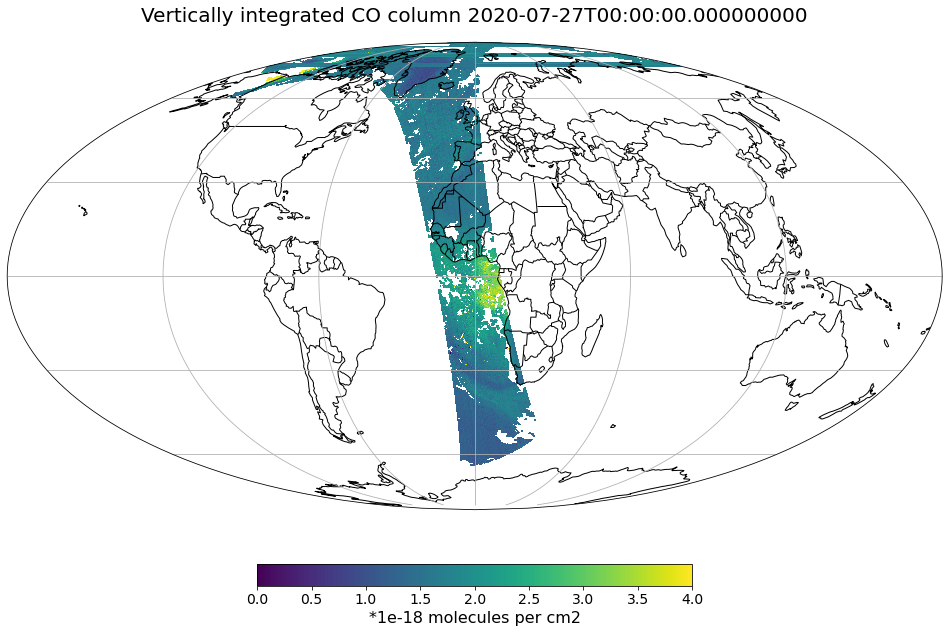

In [145]:
visualize_pcolormesh(data_array=co_2707_converted*1e-18,
                     longitude=co_2707_converted.longitude,
                     latitude=co_2707_converted.latitude,
                     projection=ccrs.Mollweide(),
                     color_scale='viridis',
                     unit='*1e-18 molecules per cm2',
                     long_name=longname + ' ' + str(co_2707_converted.time.data),
                     vmin=0, 
                     vmax=4,
                     lonmin=longitude.min(),
                     lonmax=longitude.max(),
                     latmin=latitude.min(),
                     latmax=latitude.max(),
                     set_global=True)

You can zoom into a region by specifying a `bounding box` of interest. Let's set the extent to Portugal, with: `[35.5, 44, -11, -5]`. The above plotting function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh) allows for setting a specific bounding box. You simply have to set the `set_global` key to False. It is best to adjust the projection to `PlateCarree()`, as this will be more appropriate for a regional subset.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Vertically integrated CO column 2020-07-27T00:00:00.000000000'}>)

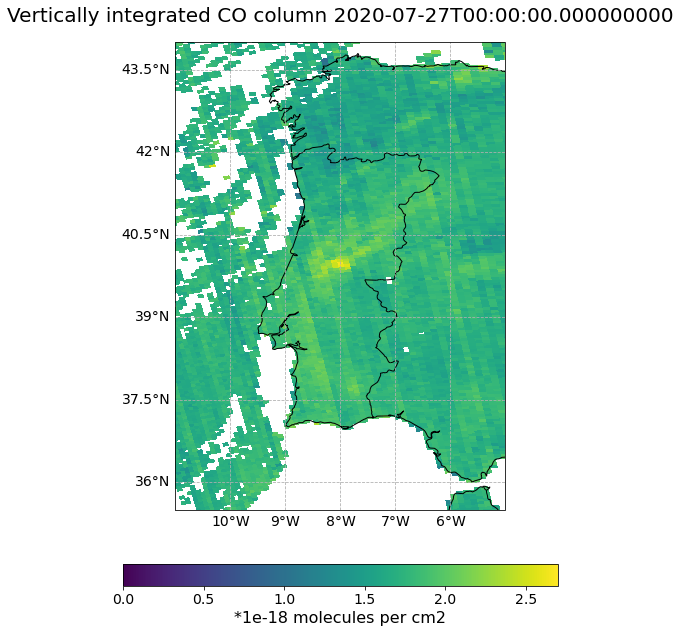

In [146]:
latmin = 35.5
latmax = 44.
lonmin = -11.
lonmax = -5

visualize_pcolormesh(data_array=co_2707_converted*1e-18,
                     longitude=co_2707_converted.longitude,
                     latitude=co_2707_converted.latitude,
                     projection=ccrs.PlateCarree(),
                     color_scale='viridis',
                     unit='*1e-18 molecules per cm2',
                     long_name=longname + ' ' + str(co_2707_converted.time.data),
                     vmin=0, 
                     vmax=2.7,
                     lonmin=lonmin,
                     lonmax=lonmax,
                     latmin=latmin,
                     latmax=latmax,
                     set_global=False)

<br>

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./22_Sentinel-3_SLSTR_FRP.ipynb"><< 22 - Sentinel-3 SLSTR FRP </a><span style="float:right;"><a href="./32_Sentinel-5P_TROPOMI_UVAI.ipynb"> 32 - Sentinel-5P TROPOMI UVAI >></a></span>

<hr>

<img src='./img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.